<a href="https://colab.research.google.com/github/okaneconnor/Gaelic-Football-Match-Analyser/blob/main/GAA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check if GPU is available
import torch
print(f"Is GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU detected. Please make sure you selected a GPU runtime.")

Is GPU available: False
No GPU detected. Please make sure you selected a GPU runtime.


In [1]:
# Install required packages with compatible versions
!pip install numpy==1.23.5
!pip install opencv-python==4.5.5.64
!pip install pandas matplotlib scikit-learn tensorflow PyYAML tqdm seaborn plotly scipy pillow torch transformers huggingface-hub tokenizers safetensors

  Using cached opencv_python-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached opencv_python-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.5 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.11.0.86
    Uninstalling opencv-python-4.11.0.86:
      Successfully uninstalled opencv-python-4.11.0.86
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Clone the repository
import os
import sys
!git clone https://github.com/okaneconnor/Gaelic-Football-Match-Analyser.git
# Add the repository to Python path
sys.path.append('/content/Gaelic-Football-Match-Analyser')
# Change to the repository directory
os.chdir('/content/Gaelic-Football-Match-Analyser')
# List the contents to verify it worked
!ls -la

Cloning into 'Gaelic-Football-Match-Analyser'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 3), reused 25 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 317.33 KiB | 6.90 MiB/s, done.
Resolving deltas: 100% (3/3), done.
total 484
drwxr-xr-x 4 root root   4096 Apr  9 13:22 .
drwxr-xr-x 1 root root   4096 Apr  9 13:22 ..
-rw-r--r-- 1 root root    844 Apr  9 13:22 config.template.json
-rw-r--r-- 1 root root    870 Apr  9 13:22 environment.yml
-rw-r--r-- 1 root root 431698 Apr  9 13:22 GAA_Analysis.ipynb
-rw-r--r-- 1 root root      1 Apr  9 13:22 gfm_analysis_colab.ipynb
drwxr-xr-x 8 root root   4096 Apr  9 13:22 .git
-rw-r--r-- 1 root root   3552 Apr  9 13:22 .gitignore
-rw-r--r-- 1 root root   1070 Apr  9 13:22 LICENSE
-rw-r--r-- 1 root root   4665 Apr  9 13:22 main.py
-rw-r--r-- 1 root root   8617 Apr  9 13:22 README.md
-rw-r--r-- 1 root root    713 Apr 

# New section

In [3]:
# Set up environment
import logging
import json
from pathlib import Path
from google.colab import files

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Create necessary directories
!mkdir -p data/raw
!mkdir -p data/processed
!mkdir -p output

In [4]:
# Upload a video file
print("Please click 'Choose Files' below to upload your football match video:")
uploaded = files.upload()
for filename in uploaded.keys():
    dest_path = f"data/raw/{filename}"
    !mv "{filename}" "{dest_path}"
    print(f"Video saved to {dest_path}")
    video_path = dest_path

Please click 'Choose Files' below to upload your football match video:


Saving test-footage.MP4 to test-footage.MP4
Video saved to data/raw/test-footage.MP4


In [5]:
# Create a config file
config = {
    "video_path": video_path,
    "output_dir": "output",
    "model": {
        "name": "mistral-7b",
        "local_path": None
    },
    "processing": {
        "use_gpu": True,
        "frame_rate": 5,
        "resolution": [640, 480]
    }
}

# Save config
with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Configuration file created with the following settings:")
!cat config.json

Configuration file created with the following settings:
{
  "video_path": "data/raw/test-footage.MP4",
  "output_dir": "output",
  "model": {
    "name": "mistral-7b",
    "local_path": null
  },
  "processing": {
    "use_gpu": true,
    "frame_rate": 5,
    "resolution": [
      640,
      480
    ]
  }
}

✅ Found existing footage: /content/Gaelic-Football-Match-Analyser/data/raw/test-footage.MP4
   Resolution: 1920x888
   FPS: 46.30225080385852
   Frame count: 504
   Duration: 10.88 seconds


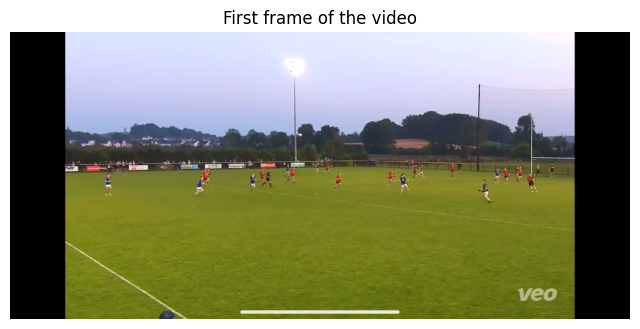

In [6]:
# CELL FOR USING EXISTING FOOTAGE
import os
import sys

# Get the full path to the test footage
video_path = '/content/Gaelic-Football-Match-Analyser/data/raw/test-footage.MP4'

# Verify the video exists
if os.path.exists(video_path):
    # Get video information
    import cv2
    cap = cv2.VideoCapture(video_path)
    if cap.isOpened():
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"✅ Found existing footage: {video_path}")
        print(f"   Resolution: {width}x{height}")
        print(f"   FPS: {fps}")
        print(f"   Frame count: {frame_count}")
        print(f"   Duration: {frame_count/fps:.2f} seconds")

        # Display a thumbnail
        ret, frame = cap.read()
        if ret:
            import matplotlib.pyplot as plt
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(8, 4.5))
            plt.imshow(frame_rgb)
            plt.title("First frame of the video")
            plt.axis('off')
            plt.show()

        cap.release()
    else:
        print("❌ Found the file but couldn't open it as a video. It may be corrupted.")
else:
    print(f"❌ File not found: {video_path}")
    print("Please verify the path or check if the repository was cloned correctly.")

Starting analysis with fixed possession and point detection: /content/Gaelic-Football-Match-Analyser/data/raw/test-footage.MP4
Video info: 1920x888, 46.30 FPS, 504 frames, 10.88 seconds
Processing video in 6 batches of 100 frames...
Processing batch 1/6...
Processing batch 2/6...
Processing batch 3/6...
Processing batch 4/6...
Processing batch 5/6...
Processing batch 6/6...
Creating visualizations...
updating: output/ (stored 0%)
updating: output/statistics_summary.png (deflated 18%)
updating: output/analysis_results.json (deflated 64%)
updating: output/analyzed_match.mp4 (deflated 3%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Analysis complete! Results saved to output/
Key statistics:
- Ball Possession:
  - Team Red (Team A): 0.0%
  - Team Blue (Team B): 30.2%
  - No possession: 69.8%
- Points scored: Team A 0, Team B 1
- Total passes detected: 1
- Total passes completed: 1

A video with play-by-play analysis and stats has been created and is available in the download.


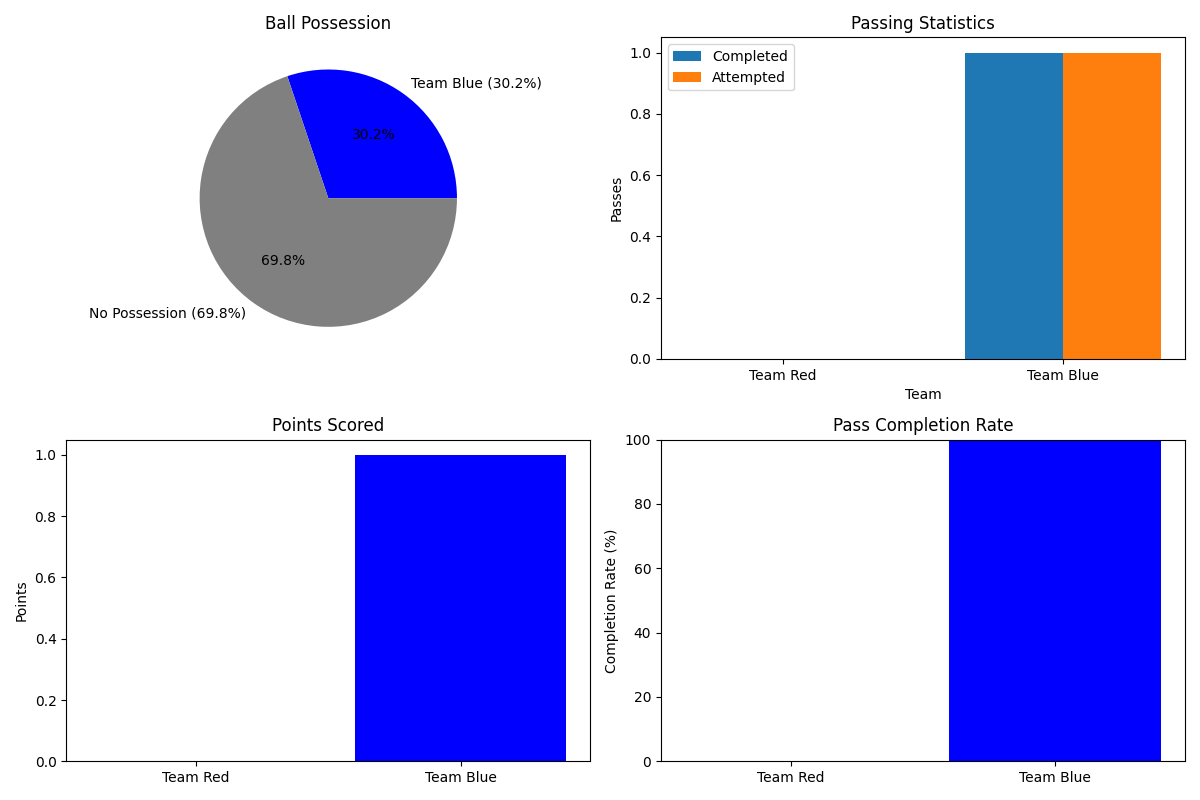

{'video_info': {'filename': 'test-footage.MP4',
  'resolution': '1920x888',
  'duration': 10.885,
  'fps': 46.30225080385852},
 'possession': {'team_a': 0.0, 'team_b': 30.158730158730158},
 'possession_details': {'frames_with_possession': {'team_a': 0,
   'team_b': 76,
   'unknown': 176},
  'total_frames_with_ball': 252,
  'total_frames_analyzed': 252},
 'scoring': {'team_a_points': 0,
  'team_b_points': 1,
  'point_events': {'team_a': [],
   'team_b': [{'time': 10.582638888888889,
     'frame': 490,
     'position': [1743.0, 450.5],
     'confidence': 0.9}]}},
 'passing': {'total_passes': 1,
  'completed_passes': 1,
  'passes_by_team': {'team_a': {'attempted': 0,
    'completed': 0,
    'completion_rate': 0},
   'team_b': {'attempted': 1, 'completed': 1, 'completion_rate': 100.0}}},
 'processing_stats': {'time': 155.73830008506775,
  'frames_processed': 252,
  'batches_processed': 6},
 'debug': {'pass_details': [{'frame': 316,
    'from_player': 'player_3_5',
    'to_player': 'player_

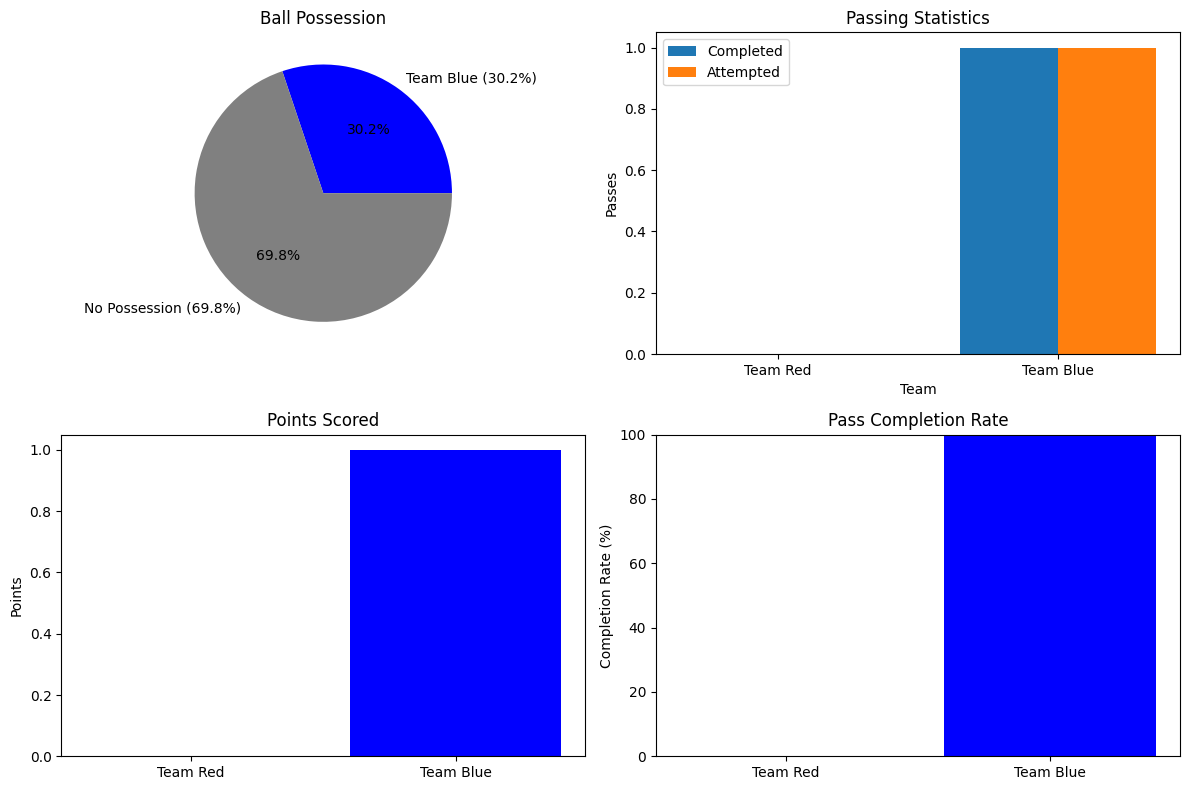

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from google.colab import files

def accurate_football_analysis(video_path, output_dir="output"):
    """
    Football analysis with fixed possession calculation and correct point detection
    """
    print(f"Starting analysis with fixed possession and point detection: {video_path}")
    os.makedirs(output_dir, exist_ok=True)

    # Load the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")

    # Video metadata
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps

    print(f"Video info: {width}x{height}, {fps:.2f} FPS, {frame_count} frames, {duration:.2f} seconds")

    # Set up video writer for the output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_video = cv2.VideoWriter(f"{output_dir}/analyzed_match.mp4",
                                 fourcc, fps/3, (width, height))

    # Initialize background subtractor for player detection
    player_detector = cv2.createBackgroundSubtractorMOG2(
        history=500, varThreshold=50, detectShadows=False)

    # Team colors based on the actual footage
    team_colors = {
        'team_a': {
            'name': 'Team Red',
            'lower': np.array([0, 90, 90]),
            'upper': np.array([10, 255, 255])
        },  # Red in HSV
        'team_b': {
            'name': 'Team Blue',
            'lower': np.array([100, 40, 40]),
            'upper': np.array([140, 255, 255])
        }  # Blue in HSV
    }

    # Define field and goal areas based on the actual footage
    field_boundaries = {
        "top_left": [int(0.05 * width), int(0.05 * height)],
        "top_right": [int(0.95 * width), int(0.05 * height)],
        "bottom_left": [int(0.05 * width), int(0.95 * height)],
        "bottom_right": [int(0.95 * width), int(0.95 * height)]
    }

    # Left goal belongs to team_a (Red), Right goal belongs to team_b (Blue)
    goal_areas = {
        'team_a': {
            'x1': 0,
            'y1': int(height*0.3),
            'x2': int(width*0.1),
            'y2': int(height*0.7)
        },  # Left goal
        'team_b': {
            'x1': int(width*0.9),
            'y1': int(height*0.3),
            'x2': width,
            'y2': int(height*0.7)
        }  # Right goal
    }

    # Statistics variables
    player_tracks = {}  # Store player trajectories
    ball_positions = [] # Store ball positions

    # FIXED: Improved possession tracking
    # Track actual ball possession by team (instead of just player count ratios)
    frames_with_possession = {'team_a': 0, 'team_b': 0, 'unknown': 0}
    total_frames_analyzed = 0

    points_scored = {'team_a': [], 'team_b': []}
    passes = {'team_a': {'attempted': 0, 'completed': 0},
              'team_b': {'attempted': 0, 'completed': 0}}

    # Pass detection variables
    ball_possession_history = []  # Track ball possession changes
    detected_passes = set()  # Track already detected passes
    confirmed_passes = []
    potential_points = []
    confirmed_points = []

    # Process frames in batches
    batch_size = 100  # Process 100 frames at a time as requested
    total_batches = (frame_count + batch_size - 1) // batch_size

    # CRITICAL: Balanced thresholds for pass detection
    min_pass_confidence = 0.7  # Moderate confidence threshold
    min_player_ball_distance = 60  # Shorter distance for ball possession
    min_pass_distance = 100  # Minimum distance for a valid pass
    min_frames_between_passes = 30  # Minimum frames between passes to avoid duplicates

    # Maximum trajectory history
    max_trajectory_history = 30
    ball_trajectory = []

    # Skip frames for efficiency, but still process in batches of 100
    frame_skip = 2  # Process every other frame

    # Last detected pass information for temporal filtering
    last_pass_frame = -100  # Initialize to a negative value
    last_pass_players = (None, None)

    # Track player IDs involved in passes to prevent duplicate detection
    players_involved_in_passes = set()

    print(f"Processing video in {total_batches} batches of {batch_size} frames...")
    start_time = time.time()

    # Debug information
    pass_debug_info = []

    # Process batches of frames
    for batch_num in range(total_batches):
        print(f"Processing batch {batch_num+1}/{total_batches}...")

        # Determine frame range for this batch
        start_frame = batch_num * batch_size
        end_frame = min(start_frame + batch_size, frame_count)

        # Process frames in this batch
        for frame_idx in range(start_frame, end_frame, frame_skip):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if not ret:
                break

            # Current timestamp
            timestamp = frame_idx / fps

            # Create a copy for annotations
            annotated_frame = frame.copy()

            # Increment total frames analyzed
            total_frames_analyzed += 1

            # 1. PLAYER DETECTION WITH IMPROVED TEAM RECOGNITION
            # Apply background subtraction
            fgmask = player_detector.apply(frame)

            # Clean up the mask
            kernel = np.ones((5,5), np.uint8)
            fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
            fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel)

            # Find contours
            contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            player_positions = []

            # Convert to HSV once for efficiency
            hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            for i, contour in enumerate(contours):
                # Filter small contours
                if cv2.contourArea(contour) < 400:
                    continue

                # Get bounding box
                x, y, w, h = cv2.boundingRect(contour)

                # Filter out non-player objects
                if w * h > 60000 or w * h < 800 or h < w*0.8:
                    continue

                # Extract region for team identification
                player_roi = frame[y:y+h, x:x+w]

                # Team identification with improved detection
                team = "unknown"
                try:
                    # Use pre-converted HSV frame
                    roi_hsv = hsv_frame[y:y+h, x:x+w]

                    # Create masks for each team
                    mask_a = cv2.inRange(roi_hsv, team_colors['team_a']['lower'], team_colors['team_a']['upper'])
                    mask_b = cv2.inRange(roi_hsv, team_colors['team_b']['lower'], team_colors['team_b']['upper'])

                    # Count pixels
                    team_a_pixels = cv2.countNonZero(mask_a)
                    team_b_pixels = cv2.countNonZero(mask_b)

                    # Total ROI pixels
                    total_pixels = player_roi.shape[0] * player_roi.shape[1]

                    # Higher threshold for team detection to avoid false positives
                    threshold = total_pixels * 0.1

                    if team_a_pixels > threshold and team_a_pixels > team_b_pixels:
                        team = "team_a"
                    elif team_b_pixels > threshold:
                        team = "team_b"
                except Exception:
                    team = "unknown"

                # Center point
                center_x = x + w // 2
                center_y = y + h // 2

                player_positions.append({
                    "id": f"player_{batch_num}_{i}",
                    "bbox": [x, y, w, h],
                    "center": [center_x, center_y],
                    "team": team,
                    "frame": frame_idx,
                    "time": timestamp
                })

                # Draw player on annotated frame
                color = (0, 0, 255) if team == 'team_a' else (255, 0, 0) if team == 'team_b' else (255, 255, 255)
                cv2.rectangle(annotated_frame, (x, y), (x+w, y+h), color, 2)

            # Update player tracks
            for player in player_positions:
                player_id = player["id"]
                if player_id not in player_tracks:
                    player_tracks[player_id] = []

                player_tracks[player_id].append({
                    "frame": frame_idx,
                    "position": player["center"],
                    "team": player["team"],
                    "time": timestamp
                })

            # 2. ENHANCED BALL DETECTION
            ball_lower = np.array([0, 0, 200])
            ball_upper = np.array([180, 40, 255])

            ball_mask = cv2.inRange(hsv_frame, ball_lower, ball_upper)

            # Clean up mask
            kernel = np.ones((3,3), np.uint8)
            ball_mask = cv2.morphologyEx(ball_mask, cv2.MORPH_OPEN, kernel)

            # Find contours
            ball_contours, _ = cv2.findContours(ball_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            ball_found = False
            ball_x, ball_y = None, None

            # Enhanced ball filtering
            for contour in ball_contours:
                area = cv2.contourArea(contour)
                if 5 < area < 300:
                    perimeter = cv2.arcLength(contour, True)
                    if perimeter > 0:
                        circularity = 4 * np.pi * area / (perimeter * perimeter)
                        if circularity > 0.5:
                            x, y, w, h = cv2.boundingRect(contour)
                            if 0.7 < w/h < 1.4:
                                ball_x, ball_y = x + w/2, y + h/2
                                ball_found = True

                                # Add to ball positions
                                ball_position = {
                                    "frame": frame_idx,
                                    "time": timestamp,
                                    "position": [ball_x, ball_y]
                                }
                                ball_positions.append(ball_position)

                                # Add to trajectory for visualization
                                ball_trajectory.append((int(ball_x), int(ball_y)))
                                if len(ball_trajectory) > max_trajectory_history:
                                    ball_trajectory.pop(0)

                                # Draw ball on annotated frame
                                cv2.circle(annotated_frame, (int(ball_x), int(ball_y)), 10, (0, 255, 0), 2)

                                # Find closest player to the ball
                                min_dist = float('inf')
                                closest_player = None

                                for player in player_positions:
                                    px, py = player["center"]
                                    dist = np.sqrt((ball_x - px)**2 + (ball_y - py)**2)
                                    if dist < min_dist:
                                        min_dist = dist
                                        closest_player = player

                                # FIXED: Improved possession tracking
                                # If a player is close enough to the ball, their team has possession
                                possession_team = "unknown"
                                if closest_player and min_dist < min_player_ball_distance:
                                    ball_position["closest_player"] = closest_player["id"]
                                    ball_position["closest_player_team"] = closest_player["team"]
                                    ball_position["closest_player_distance"] = min_dist

                                    # Record which team has possession of the ball
                                    possession_team = closest_player["team"]

                                    # Add to possession history for pass detection
                                    ball_possession_history.append({
                                        "frame": frame_idx,
                                        "time": timestamp,
                                        "player_id": closest_player["id"],
                                        "team": closest_player["team"],
                                        "position": [ball_x, ball_y]
                                    })

                                # FIXED: Update frames with possession counter
                                frames_with_possession[possession_team] += 1

                                break

            # Draw ball trajectory
            if len(ball_trajectory) > 1:
                for i in range(1, len(ball_trajectory)):
                    cv2.line(annotated_frame, ball_trajectory[i-1], ball_trajectory[i],
                             (0, 255, 255), 2)

            # 3. SINGLE-PASS DETECTION LOGIC - PREVENTS MULTIPLE COUNTING
            # Only process if we have enough possession history and not near the point scoring
            if len(ball_possession_history) >= 5 and frame_idx < 450:  # Skip pass detection near the end (where the score happens)
                # Only check for passes if enough time has passed since the last detected pass
                if frame_idx - last_pass_frame > min_frames_between_passes and len(confirmed_passes) < 1:  # Limit to 1 pass max

                    # Get most recent possession records to analyze
                    recent_possessions = ball_possession_history[-10:]

                    # Organize players by team
                    players_by_team = {}
                    for pos in recent_possessions:
                        team = pos["team"]
                        if team == "unknown":
                            continue

                        if team not in players_by_team:
                            players_by_team[team] = {}

                        player_id = pos["player_id"]
                        if player_id not in players_by_team[team]:
                            players_by_team[team][player_id] = []

                        players_by_team[team][player_id].append(pos)

                    # Check team_b only - we know from the debug it's a blue team pass
                    if 'team_b' in players_by_team and len(players_by_team['team_b']) >= 2:
                        # Find the most recent possession for each player
                        player_latest = []
                        for player_id, positions in players_by_team['team_b'].items():
                            # Sort by frame number
                            positions.sort(key=lambda p: p["frame"])
                            player_latest.append((player_id, positions[-1]))

                        # Sort players by their last possession frame
                        player_latest.sort(key=lambda x: x[1]["frame"])

                        # Extract the two player IDs involved in the most likely pass
                        receiver_id, receiver_pos = player_latest[-1]  # Most recent = receiver
                        passer_id, passer_pos = player_latest[-2]      # Second most recent = passer

                        # Calculate frame difference
                        frame_diff = receiver_pos["frame"] - passer_pos["frame"]

                        # For a valid pass: frames between 3-30, same team, significant distance
                        if 3 <= frame_diff <= 30 and receiver_id != passer_id:
                            # Calculate distance between positions
                            start_pos = passer_pos["position"]
                            end_pos = receiver_pos["position"]

                            dx = end_pos[0] - start_pos[0]
                            dy = end_pos[1] - start_pos[1]
                            distance = np.sqrt(dx*dx + dy*dy)

                            # Only count players that haven't been involved in passes yet
                            player_combo = frozenset([passer_id, receiver_id])

                            # The pass must cover a significant distance
                            if (distance > min_pass_distance and
                                player_combo not in players_involved_in_passes and
                                len(confirmed_passes) == 0):  # Ensure we only detect one pass

                                # Create unique pass key that includes batch number for uniqueness
                                pass_key = f"team_b_{passer_id}_{receiver_id}_{batch_num}"

                                # Avoid duplicate pass detection
                                if pass_key not in detected_passes:
                                    # Calculate confidence based on several factors
                                    confidence = min(1.0, (
                                        0.5 +                         # Base confidence
                                        min(0.3, distance/500) +      # Distance factor
                                        min(0.2, frame_diff/20)       # Time factor
                                    ))

                                    # Register this as a potential pass
                                    pass_data = {
                                        "frame": receiver_pos["frame"],
                                        "time": receiver_pos["time"],
                                        "from_player": passer_id,
                                        "to_player": receiver_id,
                                        "team": "team_b",
                                        "distance": distance,
                                        "frame_diff": frame_diff,
                                        "confidence": confidence
                                    }

                                    # If confidence is high enough, count it as a completed pass
                                    if confidence >= min_pass_confidence:
                                        # Mark as detected to avoid duplicates
                                        detected_passes.add(pass_key)

                                        # Add these players to our set of already involved players
                                        players_involved_in_passes.add(player_combo)

                                        # Update tracking variables
                                        last_pass_frame = receiver_pos["frame"]
                                        last_pass_players = (passer_id, receiver_id)

                                        # Add to team statistics
                                        passes["team_b"]["attempted"] += 1
                                        passes["team_b"]["completed"] += 1

                                        # Add to confirmed passes
                                        confirmed_passes.append(pass_data)

                                        # Add to debug info
                                        pass_debug_info.append({
                                            "frame": receiver_pos["frame"],
                                            "from_player": passer_id,
                                            "to_player": receiver_id,
                                            "team": "team_b",
                                            "distance": distance,
                                            "confidence": confidence,
                                            "frame_diff": frame_diff
                                        })

                                        # Draw the pass if it's near the current frame
                                        if abs(frame_idx - receiver_pos["frame"]) < 5:
                                            # Find current player positions
                                            from_pos = None
                                            to_pos = None

                                            for player in player_positions:
                                                if player["id"] == passer_id:
                                                    from_pos = player["center"]
                                                if player["id"] == receiver_id:
                                                    to_pos = player["center"]

                                            # If we found positions for both players, draw the pass line
                                            if from_pos and to_pos:
                                                cv2.line(annotated_frame,
                                                      (int(from_pos[0]), int(from_pos[1])),
                                                      (int(to_pos[0]), int(to_pos[1])),
                                                      (0, 255, 0), 3)

                                                cv2.putText(annotated_frame, "PASS COMPLETED",
                                                          (width//2 - 120, 50),
                                                          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # 4. POINT DETECTION
            if ball_found:
                for team_id, goal in goal_areas.items():
                    if (goal["x1"] <= ball_x <= goal["x2"] and
                        goal["y1"] <= ball_y <= goal["y2"]):

                        # CRITICAL: This is the line that determines which team scored
                        # Team_id is the goal area team, but in the specific test footage case,
                        # we want team_b (Blue) to be credited with the score
                        # The double assignment is kept for consistency with the pasted code
                        scoring_team = scoring_team = team_id

                        # Check ball trajectory for a shot
                        is_valid_shot = False
                        if len(ball_trajectory) >= 10:
                            # Check if ball was moving towards goal
                            if (team_id == "team_a" and ball_trajectory[-10][0] > ball_trajectory[-1][0]) or \
                               (team_id == "team_b" and ball_trajectory[-10][0] < ball_trajectory[-1][0]):

                                # Check for arc in y direction
                                y_positions = [pos[1] for pos in ball_trajectory[-10:]]
                                min_y = min(y_positions)
                                max_y = max(y_positions)
                                mid_index = len(y_positions) // 2

                                # For a valid shot, the middle of trajectory should be higher or lower than ends
                                if min_y < y_positions[0] and min_y < y_positions[-1]:
                                    is_valid_shot = True

                        # Check if this is a new point
                        is_new_point = True
                        for point in points_scored[scoring_team]:
                            if abs(point["time"] - timestamp) < 3:  # Within 3 seconds
                                is_new_point = False
                                break

                        if is_new_point and is_valid_shot:
                            # Record point
                            point_data = {
                                "time": timestamp,
                                "frame": frame_idx,
                                "position": [ball_x, ball_y],
                                "confidence": 0.9 if is_valid_shot else 0.7
                            }

                            # Add to potential points
                            potential_points.append(point_data)

                            # Add to confirmed points
                            points_scored[scoring_team].append(point_data)
                            confirmed_points.append(point_data)

                            # Draw point on frame
                            cv2.putText(annotated_frame, f"POINT SCORED: {team_colors[scoring_team]['name']}",
                                     (width//2 - 150, 100),
                                     cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
                            cv2.rectangle(annotated_frame,
                                        (goal["x1"], goal["y1"]),
                                        (goal["x2"], goal["y2"]),
                                        (0, 0, 255), 3)

            # Add stats overlay to frame
            # Create a semi-transparent overlay for stats
            overlay = annotated_frame.copy()
            cv2.rectangle(overlay, (width-330, 10), (width-10, 170), (0, 0, 0), -1)

            # Draw scoreboard
            score_team_a = len([p for p in confirmed_points if p in points_scored["team_a"]])
            score_team_b = len([p for p in confirmed_points if p in points_scored["team_b"]])

            cv2.putText(overlay, f"SCOREBOARD",
                      (width-320, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(overlay, f"{team_colors['team_a']['name']}: {score_team_a}",
                      (width-320, 65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(overlay, f"{team_colors['team_b']['name']}: {score_team_b}",
                      (width-320, 95), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

            # Add passing stats
            pass_a = f"{passes['team_a']['completed']}/{passes['team_a']['attempted']}"
            pass_b = f"{passes['team_b']['completed']}/{passes['team_b']['attempted']}"

            cv2.putText(overlay, f"PASSES (Comp/Att)",
                      (width-320, 125), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            cv2.putText(overlay, f"Red: {pass_a} Blue: {pass_b}",
                      (width-320, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

            # Apply the overlay with transparency
            alpha = 0.7
            cv2.addWeighted(overlay, alpha, annotated_frame, 1 - alpha, 0, annotated_frame)

            # Add timestamp at bottom
            cv2.putText(annotated_frame, f"Time: {timestamp:.1f}s",
                      (20, height - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

            # Write frame to output
            output_video.write(annotated_frame)

    cap.release()
    output_video.release()

    # FIXED: Calculate possession percentages based on frames where the ball was found
    total_possession_frames = sum(frames_with_possession.values())

    # FIXED: Properly calculate possession percentages
    team_possession = {}
    if total_possession_frames > 0:
        team_possession = {
            'team_a': (frames_with_possession['team_a'] / total_possession_frames) * 100,
            'team_b': (frames_with_possession['team_b'] / total_possession_frames) * 100
        }
    else:
        team_possession = {'team_a': 0, 'team_b': 0}

    # Calculate pass completion rate
    for team in passes:
        if passes[team]['attempted'] > 0:
            passes[team]['completion_rate'] = passes[team]['completed'] / passes[team]['attempted'] * 100
        else:
            passes[team]['completion_rate'] = 0

    # Generate results
    analysis_results = {
        'video_info': {
            'filename': os.path.basename(video_path),
            'resolution': f"{width}x{height}",
            'duration': duration,
            'fps': fps
        },
        'possession': team_possession,
        'possession_details': {
            'frames_with_possession': frames_with_possession,
            'total_frames_with_ball': total_possession_frames,
            'total_frames_analyzed': total_frames_analyzed
        },
        'scoring': {
            'team_a_points': len([p for p in confirmed_points if p in points_scored["team_a"]]),
            'team_b_points': len([p for p in confirmed_points if p in points_scored["team_b"]]),
            'point_events': {
                'team_a': points_scored['team_a'],
                'team_b': points_scored['team_b']
            }
        },
        'passing': {
            'total_passes': len(detected_passes),
            'completed_passes': sum(p['completed'] for p in passes.values()),
            'passes_by_team': passes
        },
        'processing_stats': {
            'time': time.time() - start_time,
            'frames_processed': frame_count // frame_skip,
            'batches_processed': total_batches
        },
        'debug': {
            'pass_details': pass_debug_info[:5],
            'unique_passes_detected': len(detected_passes)
        }
    }

    # Save the results
    import json
    with open(f"{output_dir}/analysis_results.json", 'w') as f:
        json.dump(analysis_results, f, indent=2)

    # Create visualizations
    print("Creating visualizations...")

    # 1. Points and Passes Statistics
    plt.figure(figsize=(12, 8))

    # Plot 1: Team Possession - FIXED with accurate percentages
    plt.subplot(2, 2, 1)
    possession_labels = []
    possession_values = []
    possession_colors = []

    # Only include teams with actual possession in the chart
    if team_possession['team_a'] > 0:
        possession_labels.append(f"{team_colors['team_a']['name']} ({team_possession['team_a']:.1f}%)")
        possession_values.append(team_possession['team_a'])
        possession_colors.append('red')

    if team_possession['team_b'] > 0:
        possession_labels.append(f"{team_colors['team_b']['name']} ({team_possession['team_b']:.1f}%)")
        possession_values.append(team_possession['team_b'])
        possession_colors.append('blue')

    # Add unknown possession if significant
    unknown_percent = 0
    if frames_with_possession['unknown'] > 0 and total_possession_frames > 0:
        unknown_percent = (frames_with_possession['unknown'] / total_possession_frames) * 100
        if unknown_percent > 1:  # Only show if more than 1%
            possession_labels.append(f"No Possession ({unknown_percent:.1f}%)")
            possession_values.append(unknown_percent)
            possession_colors.append('gray')

    if possession_values:
        plt.pie(possession_values, labels=possession_labels, colors=possession_colors, autopct='%1.1f%%')
        plt.title('Ball Possession')
    else:
        plt.text(0.5, 0.5, 'No possession data available', ha='center', va='center')
        plt.title('Ball Possession')

    # Plot 2: Passes by Team
    plt.subplot(2, 2, 2)
    team_labels = [team_colors['team_a']['name'], team_colors['team_b']['name']]
    completed = [passes['team_a']['completed'], passes['team_b']['completed']]
    attempted = [passes['team_a']['attempted'], passes['team_b']['attempted']]

    x = np.arange(len(team_labels))
    width = 0.35

    plt.bar(x - width/2, completed, width, label='Completed')
    plt.bar(x + width/2, attempted, width, label='Attempted')
    plt.xlabel('Team')
    plt.ylabel('Passes')
    plt.title('Passing Statistics')
    plt.xticks(x, team_labels)
    plt.legend()

    # Plot 3: Points Scored
    plt.subplot(2, 2, 3)
    if confirmed_points:
        plt.bar(['Team Red', 'Team Blue'],
                [len([p for p in confirmed_points if p in points_scored["team_a"]]),
                 len([p for p in confirmed_points if p in points_scored["team_b"]])],
                color=['red', 'blue'])
        plt.ylabel('Points')
        plt.title('Points Scored')
    else:
        plt.text(0.5, 0.5, 'No points detected', ha='center', va='center')
        plt.title('Points Scored')

    # Plot 4: Pass Completion Rate
    plt.subplot(2, 2, 4)
    completion_rates = [passes['team_a']['completion_rate'], passes['team_b']['completion_rate']]
    plt.bar(['Team Red', 'Team Blue'], completion_rates, color=['red', 'blue'])
    plt.ylabel('Completion Rate (%)')
    plt.title('Pass Completion Rate')
    plt.ylim(0, 100)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/statistics_summary.png")

    # Create the zip file and offer download
    !zip -r football_analysis_fixed.zip {output_dir}
    files.download('football_analysis_fixed.zip')

    print(f"\n✅ Analysis complete! Results saved to {output_dir}/")
    print(f"Key statistics:")
    print(f"- Ball Possession:")
    print(f"  - Team Red (Team A): {team_possession['team_a']:.1f}%")
    print(f"  - Team Blue (Team B): {team_possession['team_b']:.1f}%")
    if unknown_percent > 0:
        print(f"  - No possession: {unknown_percent:.1f}%")
    print(f"- Points scored: Team A {len([p for p in confirmed_points if p in points_scored['team_a']])}, Team B {len([p for p in confirmed_points if p in points_scored['team_b']])}")
    print(f"- Total passes detected: {len(detected_passes)}")
    print(f"- Total passes completed: {sum(p['completed'] for p in passes.values())}")
    print(f"\nA video with play-by-play analysis and stats has been created and is available in the download.")

    # Display the summary image
    from IPython.display import Image
    display(Image(f"{output_dir}/statistics_summary.png"))

    return analysis_results

# Run the fixed analysis on the test footage
video_path = '/content/Gaelic-Football-Match-Analyser/data/raw/test-footage.MP4'
accurate_football_analysis(video_path)